In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install texthero

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 5.0 MB/s 
     |████████████████████████████████| 235 kB 48.7 MB/s 
     |████████████████████████████████| 184 kB 54.0 MB/s 
     |████████████████████████████████| 1.0 MB 43.6 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.4
    Uninstalling srsly-2.4.4:
      Successfully uninstalled srsly-2.4.4
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
ERROR: pip's dependency resolver does not currently take into

In [4]:
import os
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')

In [6]:
train = pd.read_csv(os.path.join(INPUT_DIR,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [7]:
display(train.head())
print(train.shape)
display(test.head())
print(test.shape)
display(sub.head())
print(sub.shape)

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perfor...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""templat...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the...",1


(9791, 8)


,id,goal,country,duration,category1,category2,html_content
0,test_00000,5001-6000,FR,30,dance,performances,"<div class=""contents""><div><p>Bonjour ,</p><p>..."
1,test_00001,6001-7000,GB,23,publishing,children's books,"<div class=""contents""><div><p><span class=""bol..."
2,test_00002,6001-7000,GB,30,theater,plays,"<div class=""contents""><div><p>COW is a rural t..."
3,test_00003,1001-2000,CA,14,art,digital art,"<div class=""contents""><div><p>I've been creati..."
4,test_00004,1-1000,US,30,music,hip-hop,"<div class=""contents""><div><div class=""templat..."


(9800, 7)


,id,state
0,test_00000,1
1,test_00001,0
2,test_00002,0
3,test_00003,0
4,test_00004,1


(9800, 2)


In [9]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)


def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

train['content'] = cleaning(train['html_content'])
test['content'] = cleaning(test['html_content'])

train['content'] = train['content'].str.lower()
test['content'] = test['content'].str.lower()

In [10]:
train

,id,goal,country,duration,category1,category2,html_content,state,content
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://...",1,"the shillito's elves attracted close to 100,00..."
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel...",0,cultural pretzel sports bar is a place where p...
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perfor...",0,"i want to perform this piece guerilla style, o..."
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""templat...",1,"canyon de chelley, dine' (navajo) reservation,..."
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the...",1,"the story of the show, both on and off screen,..."
...,...,...,...,...,...,...,...,...,...
9786,train_09786,1-1000,US,15,music,electronic music,"<div class=""contents""><div><p>So the story beh...",0,so the story behind this is that i've been mak...
9787,train_09787,3001-4000,CA,30,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0,the high clothingmy visio...
9788,train_09788,100000+,GB,30,technology,software,"<div class=""contents""><div><p>We don't think a...",0,we don't think anybody looks forward to fillin...
9789,train_09789,79001-80000,US,35,technology,gadgets,"<div class=""contents""><div><a href=""http://dum...",1,what is droplet?droplet is a wireless butto...


In [11]:
train["contents_num_chars"] = train["content"].apply(len)
train["contents_num_words"] = train["content"].apply(lambda x: len(x.split()))
train["contents_num_unique_words"] = train["content"].apply(lambda x: len(set(w for w in x.split())))

test["contents_num_chars"] = test["content"].apply(len)
test["contents_num_words"] = test["content"].apply(lambda x: len(x.split()))
test["contents_num_unique_words"] = test["content"].apply(lambda x: len(set(w for w in x.split())))

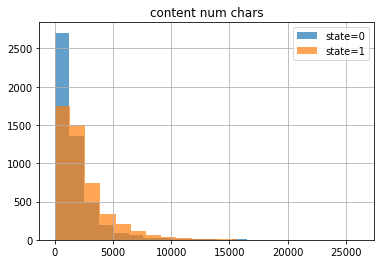

In [ ]:
plt.hist(train.loc[train.state==0]['contents_num_chars'],label='state=0',alpha=0.7,bins=20)
plt.hist(train.loc[train.state==1]['contents_num_chars'],label='state=1',alpha=0.7,bins=20)
#plt.hist(test['contents_num_chars'],label='test',alpha=0.5,bins=20)
plt.legend(loc='upper right')
plt.title('content num chars')
plt.grid()
plt.show()

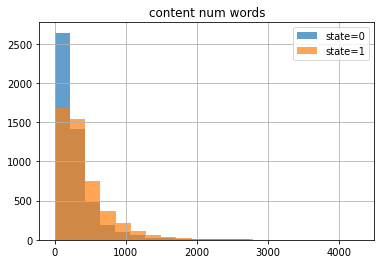

In [ ]:
plt.hist(train.loc[train.state==0]['contents_num_words'],label='state=0',alpha=0.7,bins=20)
plt.hist(train.loc[train.state==1]['contents_num_words'],label='state=1',alpha=0.7,bins=20)
#plt.hist(test['contents_num_words'],label='test',alpha=0.5,bins=40)
plt.legend(loc='upper right')
plt.title('content num words')
plt.grid()
plt.show()

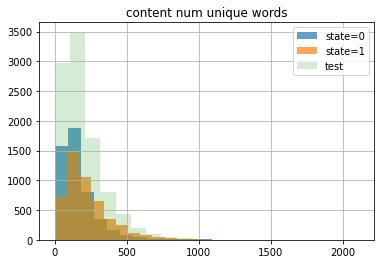

In [ ]:
plt.hist(train.loc[train.state==0]['contents_num_unique_words'],label='state=0',alpha=0.7,bins=20)
plt.hist(train.loc[train.state==1]['contents_num_unique_words'],label='state=1',alpha=0.7,bins=20)
plt.hist(test['contents_num_unique_words'],label='test',alpha=0.2,bins=20)
plt.legend(loc='upper right')
plt.title('content num unique words')
plt.grid()
plt.show()

In [ ]:
train["html_contents_num_chars"] = train["html_content"].apply(len)
train["html_contents_num_words"] = train["html_content"].apply(lambda x: len(x.split()))

test["html_contents_num_chars"] = test["html_content"].apply(len)
test["html_contents_num_words"] = test["html_content"].apply(lambda x: len(x.split()))

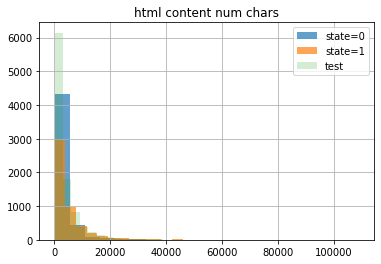

In [ ]:
plt.hist(train.loc[train.state==0]['html_contents_num_chars'],label='state=0',alpha=0.7,bins=20)
plt.hist(train.loc[train.state==1]['html_contents_num_chars'],label='state=1',alpha=0.7,bins=20)
plt.hist(test['html_contents_num_chars'],label='test',alpha=0.2,bins=30)
plt.legend(loc='upper right')
plt.title('html content num chars')
plt.grid()
plt.show()

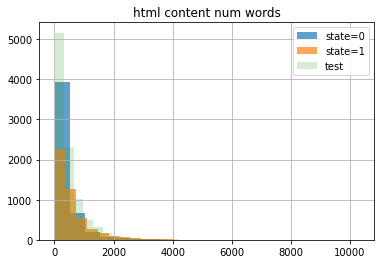

In [ ]:
plt.hist(train.loc[train.state==0]['html_contents_num_words'],label='state=0',alpha=0.7,bins=20)
plt.hist(train.loc[train.state==1]['html_contents_num_words'],label='state=1',alpha=0.7,bins=20)
plt.hist(test['html_contents_num_words'],label='test',alpha=0.2,bins=30)
plt.legend(loc='upper right')
plt.title('html content num words')
plt.grid()
plt.show()

In [ ]:
def create_corpus(df,state=1,isTrain=True):
    corpus=[]
    
    if isTrain:
      for x in df[df.state==state].content.str.split():
          for i in x:
              corpus.append(i)
    else:
      for x in df.content.str.split():
          for i in x:
              corpus.append(i)
    return corpus

In [ ]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
np.array(stop)

array({'off', "don't", 'only', 'o', 'between', 'how', 'while', 'than', 'ma', "isn't", "won't", 'shan', 'doesn', 'because', 'd', 'as', "you'd", 'if', 'yours', 'what', 'out', "wouldn't", 's', 'did', 'her', 'whom', 'mightn', 'won', 'we', 'against', 'here', 'in', 'this', 'no', 'now', 'be', "hasn't", 've', 'y', 'hadn', 'should', 'been', 'nor', 'under', 'they', "it's", 'doing', 'aren', 'has', 'will', 'after', 'hasn', "shouldn't", 'i', 'yourself', 'couldn', 'further', 'again', 'an', 'before', 'down', 'which', 'a', 'him', 'too', 'for', "you're", 'on', 'and', "mightn't", "aren't", 'into', 'were', 'don', 'am', 'why', 'had', 'very', 'ours', 'such', 'have', 'when', 'she', 'about', 'that', 'does', 'where', "couldn't", 'the', 'below', 'your', "needn't", 'there', 'm', 'was', 'isn', 'is', 'having', 'those', 'theirs', 'needn', 'them', 'up', 'until', 'some', "should've", "you'll", "haven't", 'through', 'didn', 'he', 'herself', 'at', 'mustn', 'more', 'all', 't', 'its', 're', 'itself', 'his', 'ourselves',

<BarContainer object of 10 artists>

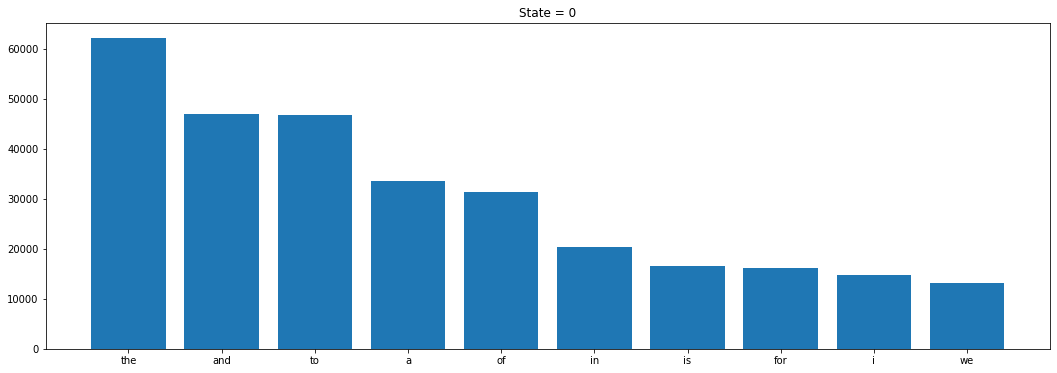

In [ ]:
corpus_0=create_corpus(train,state=0,isTrain=True)

dic=defaultdict(int)
for word in corpus_0:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.title('State = 0')
plt.bar(x,y)

<BarContainer object of 10 artists>

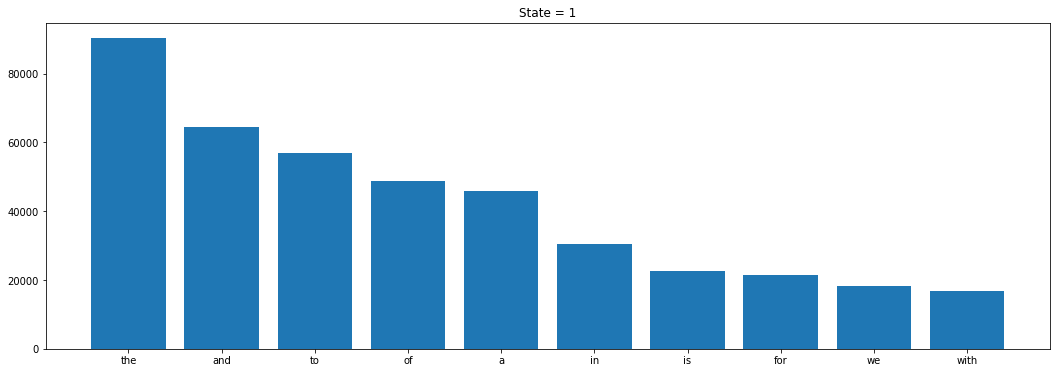

In [ ]:
corpus_1=create_corpus(train,state=1,isTrain=True)

dic=defaultdict(int)
for word in corpus_1:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.title('State = 1')
plt.bar(x,y)

<BarContainer object of 10 artists>

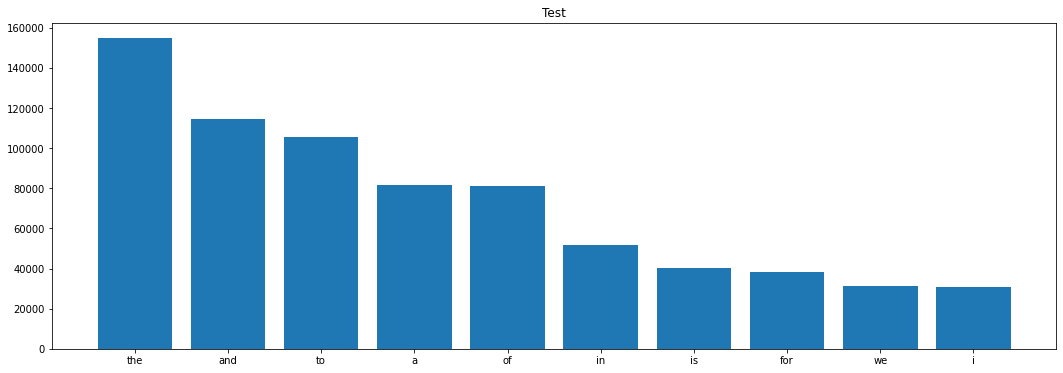

In [ ]:
corpus_test=create_corpus(test,state=0,isTrain=False)

dic=defaultdict(int)
for word in corpus_test:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.title('Test')
plt.bar(x,y)

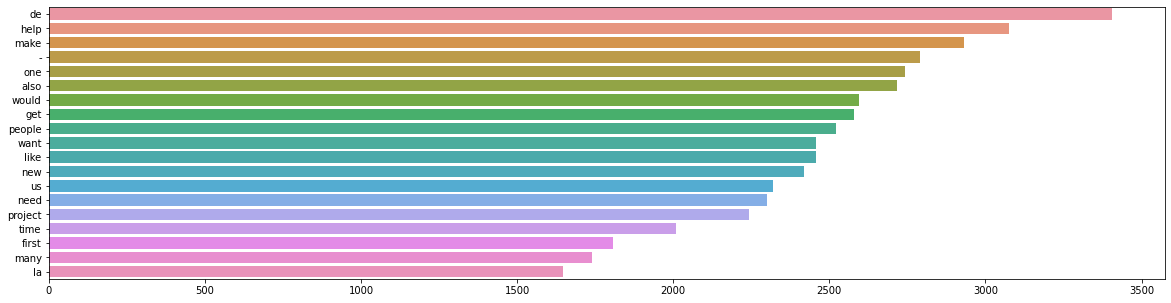

In [ ]:
plt.figure(figsize=(20,5))
counter=Counter(corpus_0)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:80]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

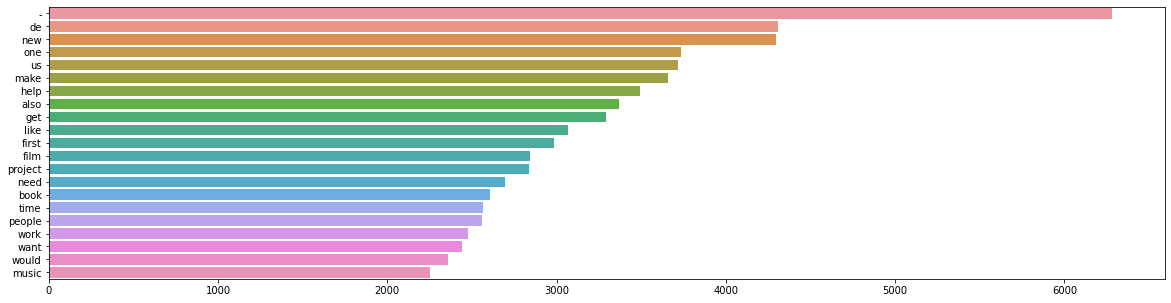

In [ ]:
plt.figure(figsize=(20,5))
counter=Counter(corpus_1)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:80]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

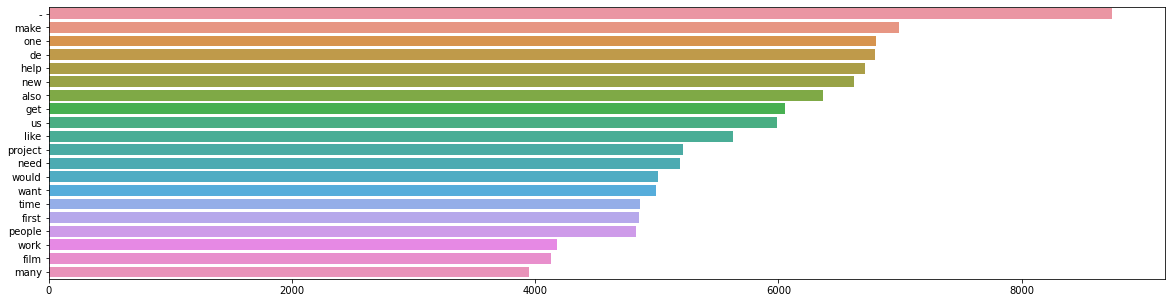

In [ ]:
plt.figure(figsize=(20,5))
counter=Counter(corpus_test)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:80]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [ ]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

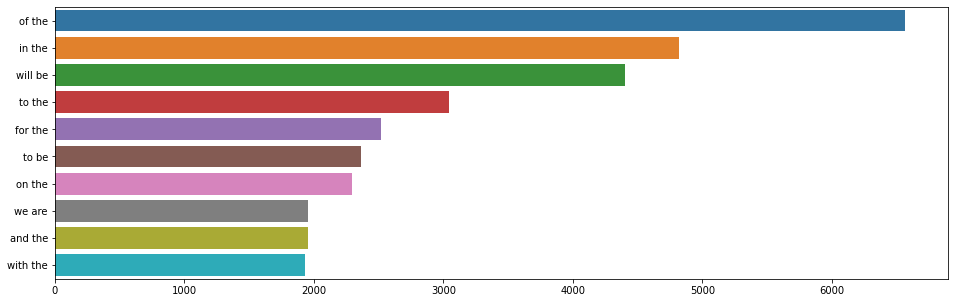

In [ ]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(train.loc[train.state==0]['content'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

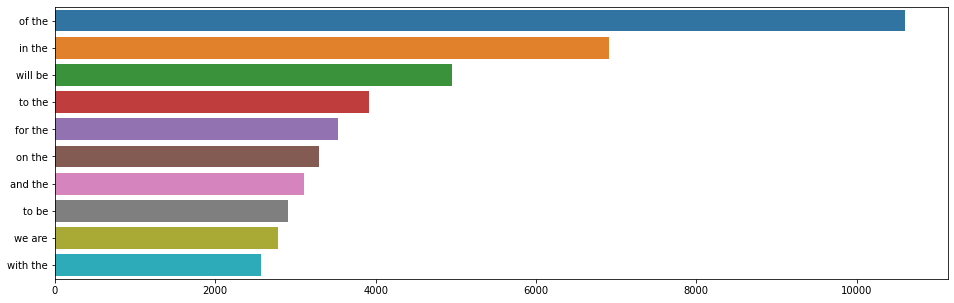

In [ ]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(train.loc[train.state==1]['content'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

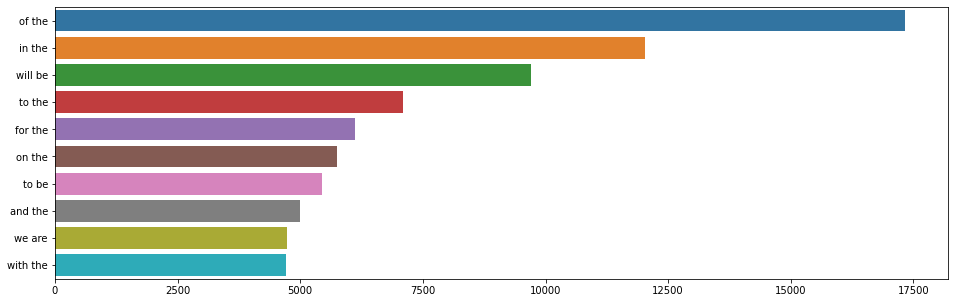

In [ ]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(test['content'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

1409211
['cultural', 'pretzel', 'sports', 'bar', 'is', 'a', 'place', 'where', 'people', 'can']


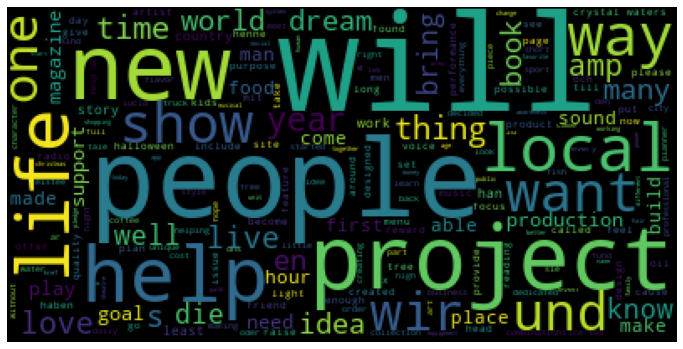

In [ ]:
print(len(corpus_0))
print(corpus_0[:10])
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_0[:8000]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

1967429
['the', "shillito's", 'elves', 'attracted', 'close', 'to', '100,000', 'people', 'each', 'year.']


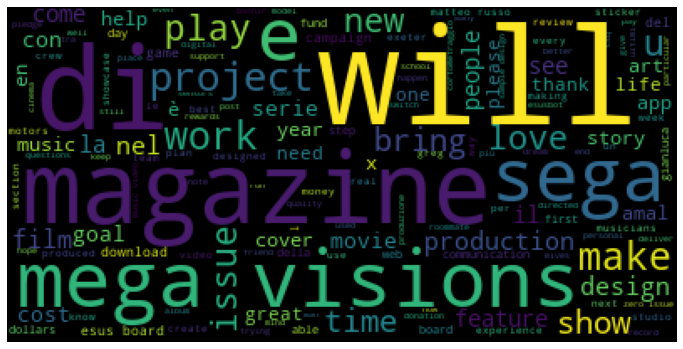

In [ ]:
print(len(corpus_1))
print(corpus_1[:10])
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_1[:5000]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

3440739
['bonjour', ',je', "m'appelle", 'morgane', 'hilgers.', 'je', 'suis', 'maquilleuse', 'depuis', '15']


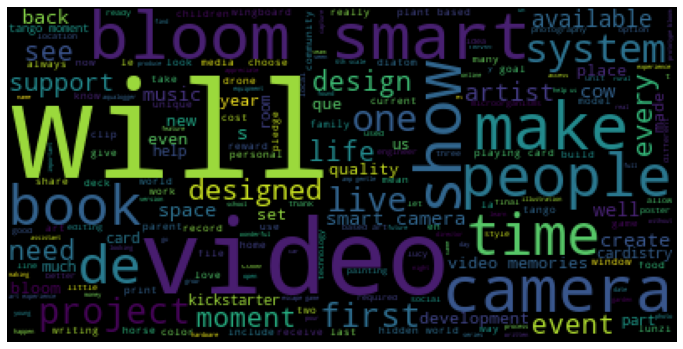

In [ ]:
print(len(corpus_test))
print(corpus_test[:10])
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_test[:10000]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
test['success_rate'] = test['country'].map(train.groupby('country')['state'].mean())
test

,id,goal,country,duration,category1,category2,html_content,content,contents_num_chars,contents_num_words,contents_num_unique_words,html_contents_num_chars,html_contents_num_words,success_rate
0,test_00000,5001-6000,FR,30,dance,performances,"<div class=""contents""><div><p>Bonjour ,</p><p>...","bonjour ,je m'appelle morgane hilgers. je suis...",2379,407,250,2516,408,0.503311
1,test_00001,6001-7000,GB,23,publishing,children's books,"<div class=""contents""><div><p><span class=""bol...",the projectthe hidden world of microorganisms ...,3047,510,251,6252,875,0.549852
2,test_00002,6001-7000,GB,30,theater,plays,"<div class=""contents""><div><p>COW is a rural t...","cow is a rural tragicomedy with songs, written...",4329,716,421,5921,816,0.549852
3,test_00003,1001-2000,CA,14,art,digital art,"<div class=""contents""><div><p>I've been creati...",i've been creating landscape images using crea...,1520,265,154,1587,266,0.469298
4,test_00004,1-1000,US,30,music,hip-hop,"<div class=""contents""><div><div class=""templat...",ive been making hip hop music for ten years no...,532,104,70,756,117,0.500362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,test_09795,4001-5000,US,29,music,world music,"<div class=""contents""><div><h1 class=""page-anc...",how tibetana startedit all began after the ter...,2381,398,238,14918,1506,0.500362
9796,test_09796,10001-11000,US,30,publishing,children's books,"<div class=""contents""><div><p><span class=""bol...",the wild waves whist is a board book that take...,7106,1153,567,26882,2910,0.500362
9797,test_09797,2001-3000,US,30,music,hip-hop,"<div class=""contents""><div><h1 class=""page-anc...",,0,0,0,84,4,0.500362
9798,test_09798,7001-8000,US,30,theater,plays,"<div class=""contents""><div><p>Have you ever re...",have you ever read a book or seen a movie and ...,2335,410,226,2427,417,0.500362
